<a href="https://colab.research.google.com/github/Ziqi-Li/GEO4162C/blob/main/notebooks/Point_Pattern_Anlysis_0922.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Point Pattern Analysis
---- on Cholera outbreaks in London in 1853

In this example, I will demostrate how to perform KDE analysis and Distance functions in Python using the classic Cholera map from Dr. John Snow.

Kudos to Robin Wilson who digitized all the data and put them into fridenly GIS format. The raw data are obtained from here:
http://blog.rtwilson.com/john-snows-famous-cholera-analysis-data-in-modern-gis-formats/


Specifically,we would need these packages for doing the analysis:
- `rasterio`: this is a package for working on raster data in python. We are not working with rasters, but the reason to have it here is to display a GeoTiff image as the basemap which was rectified to align with the GIS shapefiles.
- `seaborn`: this is actually a visualization package; however, they do have KDE function which can be used for 2D spatial data.
- `pointpats`: this is a package for conducting PPA and nearest neigher analysis. We need to use this to compute e.g. G distance function.



`rasterio` and `pointpats` are not pre-installed in Google Colab, so you need to install them manually by using the `pip` command:

`pip install package`

**Note**: You need to re-install packages (by re-running this cell) if you are disconnected from the server.


In [1]:
pip install -q rasterio

In [2]:
pip install -q pointpats

## Step 1
Import all the packages needed

In [3]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from pointpats import distance_statistics as stats
from pointpats import PointPattern, PoissonPointProcess

## Step 2
Read in two shapefiles:

- SnowGIS/Cholera_Deaths.shp is a Point shapefile with all the deaths and locations
- SnowGIS/Pumps.shp is a Point shapefile with all the pumps

Since they are both shapefiles, once we read them into python using `gpd.read_file()`, we have GeoDataFrames.

In [4]:
cases = gpd.read_file("https://raw.githubusercontent.com/Ziqi-Li/GEO4162C/main/data/SnowGIS/Cholera_Deaths.shp")
pump = gpd.read_file("https://raw.githubusercontent.com/Ziqi-Li/GEO4162C/main/data/SnowGIS/Pumps.shp")

It is always the best practice to check the data first before we move next. For example, you would need to do these things:

- 1. Check the data table to know the attributes in the GeoDataFrame
- 2. Check the geometry, to see whether you can plot them
- 3. Check whether the shapefiles you read in are having the same `crs`

In [5]:
cases.head() #This returns you the first 5 rows in the GeoDataFrame

,Id,Count,geometry
0,0,3,POINT (529308.741 181031.352)
1,0,2,POINT (529312.164 181025.172)
2,0,1,POINT (529314.382 181020.294)
3,0,1,POINT (529317.380 181014.259)
4,0,4,POINT (529320.675 181007.872)


In [6]:
cases.crs #This returns you the crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<Axes: >

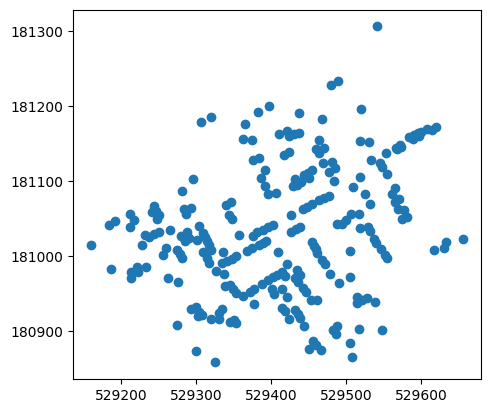

In [7]:
cases.plot() #This returns you a map of all the cases

In [8]:
pump.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<Axes: >

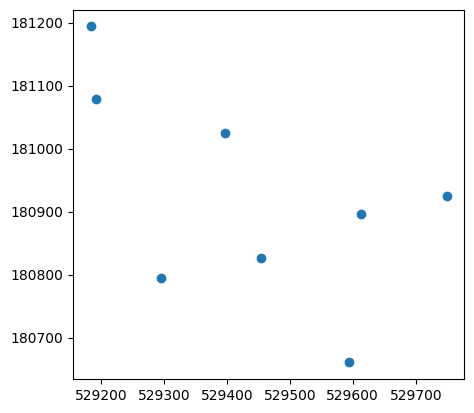

In [9]:
pump.plot()

## Step 3
Make a simple map overlaying cases with pumps

<Axes: >

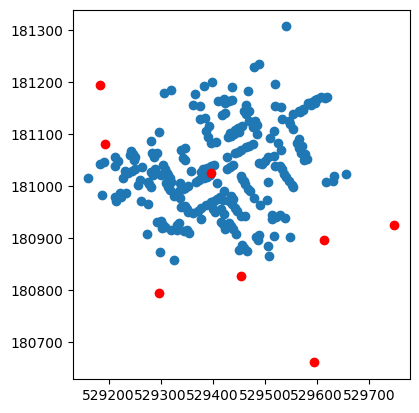

In [10]:
ax = cases.plot() #First we need to create an axis
pump.plot(ax=ax,color="red") #Then plot the pumps using thes previously created axis as a parameter in the `plot()`

<Axes: >

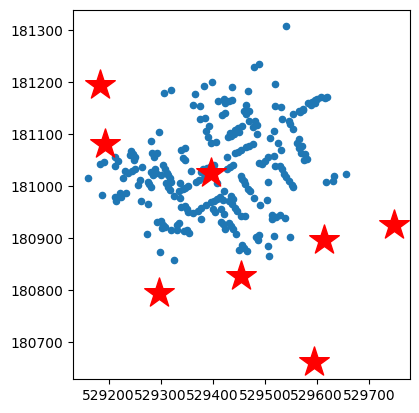

In [11]:
ax = cases.plot(markersize = 20)
#Check out here for differernt shapes of the markers:
#https://matplotlib.org/api/markers_api.html
pump.plot(ax=ax,markersize=500,marker="*",color="red")

## Step 4

Read in the TIF basemap 'SnowGIS/SnowMap.tif' with rasterio

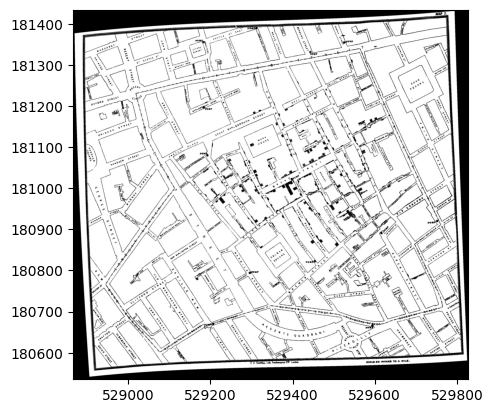

<Axes: >

In [12]:
basemap = rasterio.open('https://raw.githubusercontent.com/Ziqi-Li/GEO4162C/main/data/SnowGIS/SnowMap.tiff')
show(basemap)

## Step 5
Overlay maps together

<Axes: >

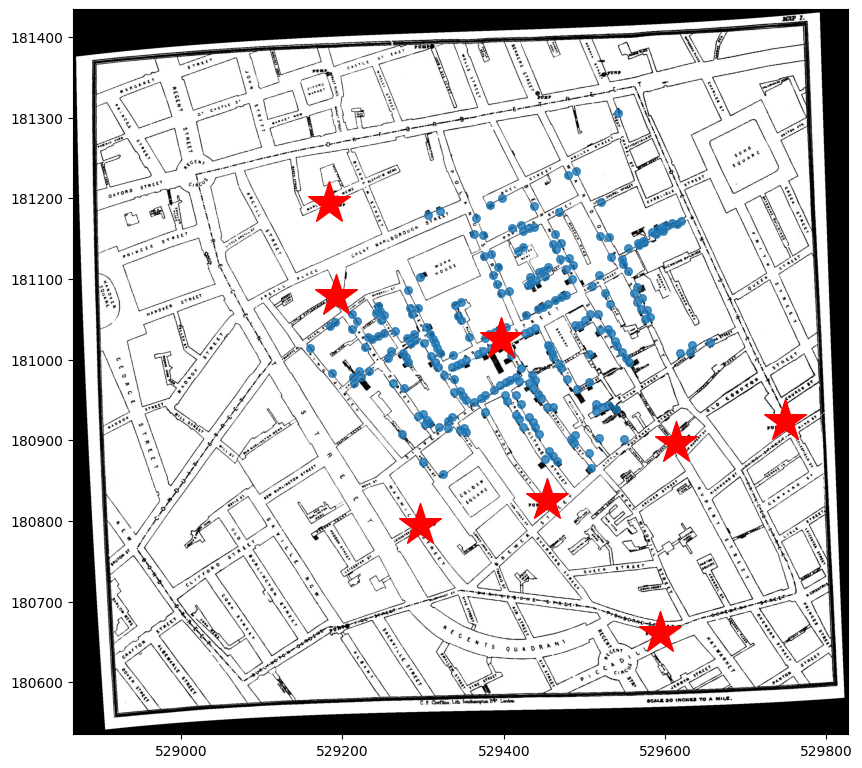

In [13]:
#First we create a figure with a size of (10,10)
f, ax = plt.subplots(figsize=(10,10))

#Plot each layer, with the same axis `ax`
show(basemap,ax=ax)

cases.plot(ax=ax, markersize = 30,alpha=0.8)

pump.plot(ax=ax,markersize=1000, marker="*",color="red")


## Step 6
Performing Kernel Density Estimation(KDE)

The function `sns.kdeplot()` takes several parameters:
- 1. the GeoDataFrame `cases`
- 2. the x and y coordinates, of which we can extract from the GeoDataFrame as `cases.geometry.x` and `cases.geometry.y`
- 3. the `bw_method` is the bandwidth of the KDE.
- 4. the `fill` parameter indicates whether you want a countour map or a filled color map
- 5. the `cmap` parameter indicates the colors you want to use
- 6. the `alpha` parameter indicates the level of transparency.

Basically 4, 5, 6 are styles parameters you could change.

The codes for performing a KDE are:

<Axes: >

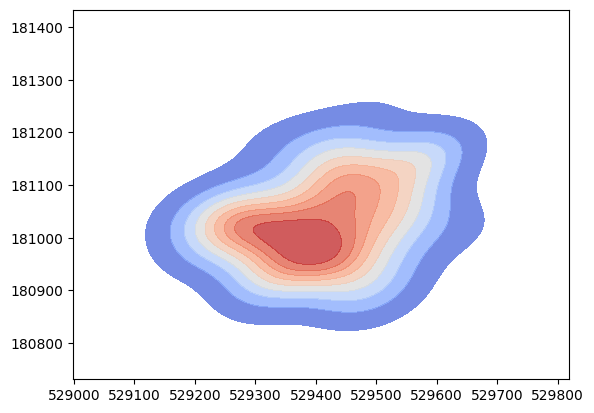

In [14]:
sns.kdeplot(data=cases, x=cases.geometry.x, y=cases.geometry.y, bw_method=0.5, fill=True,
            cmap="coolwarm",alpha=0.8)

Lets overlay the kde on top of our map. Note that you need to specify the kdeplot to be plotted on the same axis as the rest of your maps. So we need to add `ax=ax` in `sns.kdeplot(ax=ax,...)`.

<Axes: >

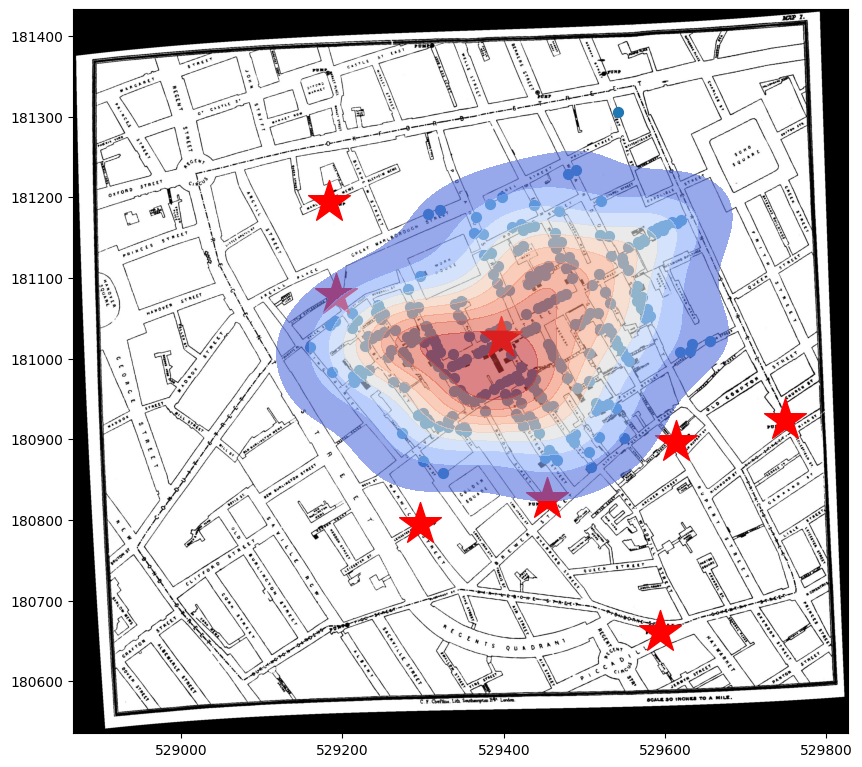

In [15]:
f, ax = plt.subplots(figsize=(10,10))
show(basemap,ax=ax)
cases.plot(ax=ax, markersize = 50)
pump.plot(ax=ax,markersize=1000,marker="*",color="red")

sns.kdeplot(ax=ax, data=cases, x=cases.geometry.x, y=cases.geometry.y, bw_method=0.5, fill=True,
            cmap="coolwarm",alpha=0.6)

We can see that the hotsplot center aligns quite well with the central pump!

Another important parameter in `sns.kdeplot()` is that there is a `weights` parameter which you could use it to weigh your locations based on the number of cases at each location.
- First lets revisit the cases GeoDataFrame, and we find there is a column called "Count".
- Then, lets use this `Count` as the weights in KDE. To do this, add `weights=cases.Count` to your existing kde function

In [16]:
cases.head()

,Id,Count,geometry
0,0,3,POINT (529308.741 181031.352)
1,0,2,POINT (529312.164 181025.172)
2,0,1,POINT (529314.382 181020.294)
3,0,1,POINT (529317.380 181014.259)
4,0,4,POINT (529320.675 181007.872)


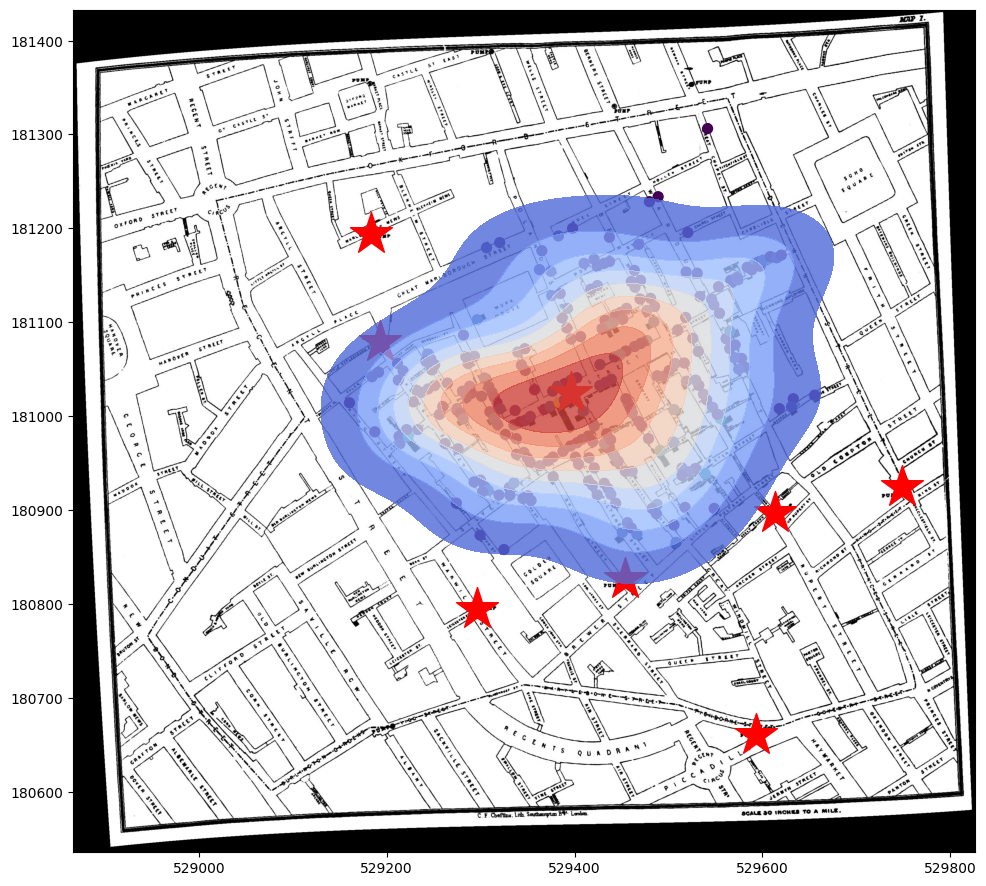

In [17]:
f, ax = plt.subplots(figsize=(10,10))
show(basemap,ax=ax,adjust=None)
cases.plot(ax=ax, markersize = 50,column="Count")
pump.plot(ax=ax,markersize=1000,marker="*",color="red")

sns.kdeplot(ax=ax,data=cases, x=cases.geometry.x, y=cases.geometry.y, bw_method=0.5, fill=True,
            cmap="coolwarm",alpha=0.8,weights=cases.Count)

plt.tight_layout()
#plt.savefig('choloera.png',dpi=600)

What you can find? Basically the KDE hotest spot points exactly to the central pump! Would it make Dr. John Snow's life easier if he could do KDE?

## Step 7
## Nearest Neighbor Analysis

The next section we would be conducting nearest neighbor analysis with distance functions and significance tests. This is easily done in the awesome `pointpats` package.

First, lets extract the x and y coordinates from the `cases` GeoDataFrame and put them as a 2d array.

In [18]:
x = cases.geometry.x.values
y = cases.geometry.y.values
points = np.array(list(zip(x,y)))

In [19]:
points

array([[529308.74142004, 181031.35154643],
       [529312.16357133, 181025.17240113],
       [529314.38242946, 181020.29368842],
       [529317.37964483, 181014.25877069],
       [529320.67544894, 181007.87162814],
       [529336.68415395, 181006.0062458 ],
       [529290.14676231, 181024.36597746],
       [529301.02286876, 181021.17630379],
       [529284.99866998, 181020.20361575],
       [529288.35938885, 181031.83006843],
       [529280.60923584, 181026.57168662],
       [529264.72089254, 181035.19790976],
       [529274.93194966, 181008.03777838],
       [529278.33502909, 181002.95226157],
       [529281.35012567, 180997.13428039],
       [529259.6098063 , 181010.28340058],
       [529256.18292592, 181001.82936416],
       [529309.82320163, 181004.72540226],
       [529314.13218069, 180997.38111357],
       [529317.99714897, 180991.27468127],
       [529250.95785343, 181032.50998808],
       [529247.96895349, 181049.24639237],
       [529231.44834441, 181027.67472078],
       [529

Second, lets create a `PointPattern()` class using the points

In [20]:
pp = PointPattern(points)

/usr/local/lib/python3.10/dist-packages/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [21]:
pp

The `knn` function would return you each point's nearest neighbor and the distance to that neighbor.

In [22]:
pp.knn()

(array([[  1],
        [  2],
        [  1],
        [  2],
        [  3],
        [ 66],
        [  8],
        [  6],
        [  6],
        [  6],
        [  8],
        [ 20],
        [ 13],
        [ 12],
        [ 13],
        [ 16],
        [ 15],
        [ 18],
        [ 19],
        [ 18],
        [ 24],
        [ 25],
        [ 23],
        [ 22],
        [ 20],
        [ 21],
        [ 28],
        [ 26],
        [ 26],
        [ 30],
        [ 29],
        [ 29],
        [ 33],
        [ 32],
        [ 33],
        [ 22],
        [ 37],
        [ 38],
        [ 37],
        [ 41],
        [ 41],
        [ 39],
        [ 43],
        [ 42],
        [ 48],
        [ 46],
        [ 45],
        [ 46],
        [ 44],
        [ 52],
        [ 51],
        [ 50],
        [ 50],
        [ 54],
        [ 53],
        [ 54],
        [ 58],
        [ 58],
        [ 81],
        [ 64],
        [ 61],
        [ 62],
        [ 63],
        [ 62],
        [ 59],
        [ 66],
        [ 

Next, lets generate 100 CSRs (each of them is a Poission process) as our null benchmark. Remeber, this would be our confidence envelope for significance test.

In [23]:
CSRs = PoissonPointProcess(pp.window, pp.n, 100, asPP=True) # simulate CSR 100 times

/usr/local/lib/python3.10/dist-packages/libpysal/cg/shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/libpysal/cg/shapes.py:103: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


Run a G distance `stats.Genv()` function and visualize it.

It shows that the CSR's G curve is **above** the confidence envelope (red curves), indicating a **significant clustered** pattern we obseve in the Cholera map.

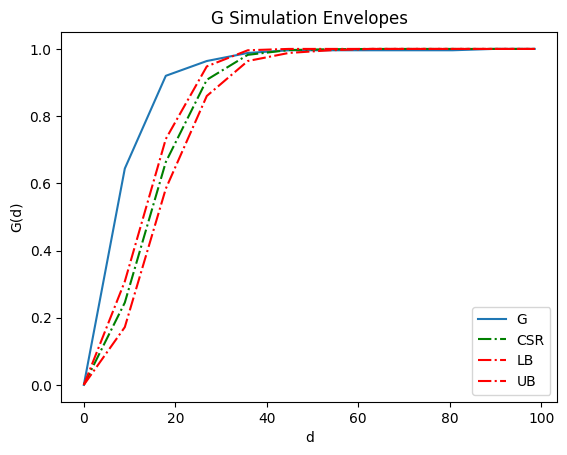

In [24]:
genv = stats.Genv(pp, realizations=CSRs)
genv.plot()

You could also do K or F distance functions easily. Similarly, the CSR's K curve is  **above** the confidence envelope (red curves), indicating a **significant clustered** pattern we obseve in the Cholera map.

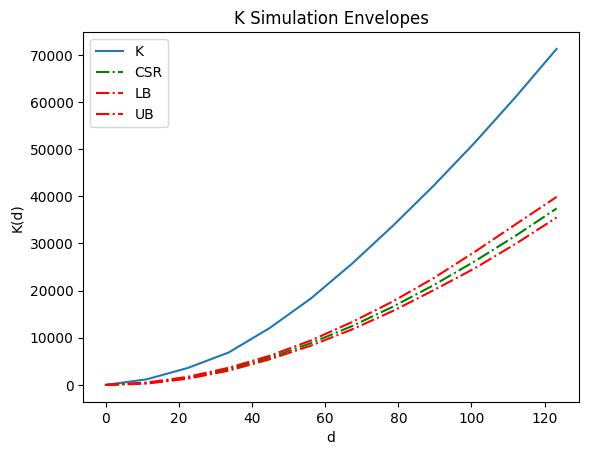

In [25]:
kenv = stats.Kenv(pp, realizations=CSRs) # call Fenv for F function
kenv.plot()

The CSR's F curve is  **below** the confidence envelope (red curves), indicating a **significant clustered** pattern we obseve in the Cholera map.

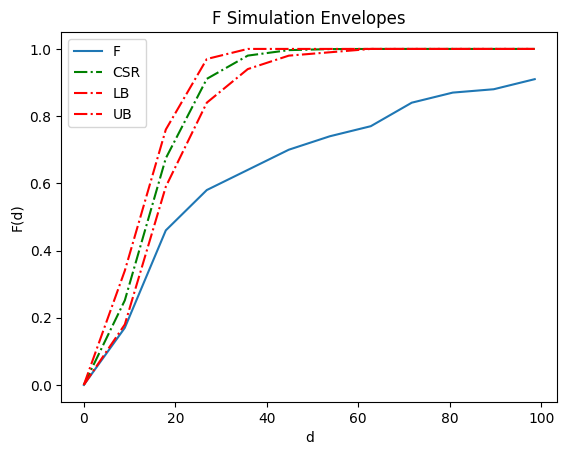

In [26]:
import warnings
warnings.filterwarnings('ignore')
fenv = stats.Fenv(pp, realizations=CSRs) # call Fenv for F function
fenv.plot()